In [95]:
import torch 
from torch.utils.data import DataLoader
import requests
import spacy
import re
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import torchdata.datapipes as dp
import urllib.request
from bs4 import BeautifulSoup

In [441]:
filename = 'val.txt'
file=open(filename)
lines = file.readlines()
lines[0]
file.close()

In [442]:
lines[-1]

'He sprang from the cabin-window as he said this, upon the ice raft which lay close to the vessel. He was soon borne away by the waves and lost in darkness and distance. '

In [443]:
output = []
for line in lines:
    if line[:7]=='Chapter' or line=='\n':
        continue
    else:
        output.append(line.lower())
        

In [444]:
file=open(filename, 'a')
file.write(''.join(output))

65853

see
https://betterprogramming.pub/intro-to-rnn-character-level-text-generation-with-pytorch-db02d7e18d89
https://pytorch.org/tutorials/beginner/torchtext_custom_dataset_tutorial.html

In [492]:
eng = spacy.load("en_core_web_sm")
def engTokenize(text):
    """
    Tokenize an English text and return a list of tokens
    """
    return [token.text for token in eng.tokenizer(text)]

def getTokens(data_iter):
    """
    Function to yield tokens from an iterator
    """
    for eng in data_iter:
        if len(eng) != 0:
            if re.match('[0-9 ]+', eng[0]) == None: # sort out the lines that only contains spaces and numbers
                yield engTokenize(eng[0])
def getTransform(vocab):
    """
    Create transforms based on given vocabulary. The returned transform is applied to sequence
    of tokens.
    """
    text_tranform = T.Sequential(
        ## converts the sentences to indices based on given vocabulary
        T.VocabTransform(vocab=vocab),
        ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
        # 1 as seen in previous section
        T.AddToken(1, begin=True),
        ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
        # 2 as seen in previous section
        T.AddToken(2, begin=False)
    )
    return text_tranform

In [493]:
FILE_PATH = 'train.txt'

data_pipe = dp.iter.IterableWrapper([FILE_PATH])
data_pipe = dp.iter.FileOpener(data_pipe, mode='r')
data_pipe = data_pipe.parse_csv(skip_lines=0, delimiter='.', as_tuple=True)
for sample in data_pipe:
    print(engTokenize(sample[0]))
    break

['i', 'am', 'by', 'birth', 'a', 'genevese', ',', 'and', 'my', 'family', 'is', 'one', 'of', 'the', 'most', 'distinguished', 'of', 'that', 'republic']


In [494]:
source_vocab = build_vocab_from_iterator(
    getTokens(data_pipe),
    min_freq=2,
            specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
            special_first=True
)
'''
<sos> for start of sentence

<eos> for end of sentence

<unk> for unknown words. An example of unknown word is the one skipped because of min_freq=2.

<pad> is the padding token. 
'''
source_vocab.set_default_index(source_vocab['<unk>']) # setting <unk> instead of that unknown word
print(source_vocab.get_itos()[:30])

['<pad>', '<sos>', '<eos>', '<unk>', ',', 'the', 'i', 'and', 'of', 'my', 'to', '“', 'a', 'in', 'that', ';', 'was', 'me', 'you', 'had', 'with', 'but', 'which', 'this', 'for', 'not', 'on', 'from', 'it', 'as']


In [495]:
temp_list = list(data_pipe)
some_sentence = temp_list[1][0]
print("Some sentence=", end="")
print(some_sentence)
transformed_sentence = getTransform(source_vocab)(engTokenize(some_sentence))
print("Transformed sentence=", end="")
print(transformed_sentence)
index_to_string = source_vocab.get_itos()
for index in transformed_sentence:
    print(index_to_string[index], end=" ")

Some sentence=as the circumstances of his marriage illustrate his character, i cannot refrain from relating them
Transformed sentence=[1, 29, 5, 350, 8, 33, 310, 3, 33, 3, 4, 6, 53, 25, 3, 27, 3, 98, 2]
<sos> as the circumstances of his marriage <unk> his <unk> , i can not <unk> from <unk> them <eos> 

In [496]:
def applyTransform(sequence):
    """
    Apply transforms to sequence of tokens and create input & target vectors
    """
    tokenized = engTokenize(sequence[0])
    transformed = getTransform(source_vocab)(tokenized)

    return (transformed[:-1], # X
            transformed[1:]) # target


        
data_pipe = data_pipe.map(applyTransform) ## Apply the function to each element in the iterator

In [497]:
i = 0
for sample in data_pipe:
    print("\n\nInput sentence=", end="")
    index_to_string = source_vocab.get_itos()
    #for index in sample[0]:
        #print(index_to_string[index], end=" ")
    print("Transformed input sentence=", end="")
    print(sample[0])
    
    print("\n\nOutput sentence=", end="")
    for index in sample[1]:
        print(index_to_string[index], end=" ")
    print("Transformed output sentence=", end="")
    print(sample[1])
    if i > 2:
        break
    i += 1



Input sentence=Transformed input sentence=[1, 6, 69, 31, 551, 12, 3, 4, 7, 9, 452, 42, 44, 8, 5, 103, 3, 8, 14, 3]


Output sentence=i am by birth a <unk> , and my family is one of the most <unk> of that <unk> <eos> Transformed output sentence=[6, 69, 31, 551, 12, 3, 4, 7, 9, 452, 42, 44, 8, 5, 103, 3, 8, 14, 3, 2]


Input sentence=Transformed input sentence=[1, 29, 5, 350, 8, 33, 310, 3, 33, 3, 4, 6, 53, 25, 3, 27, 3, 98]


Output sentence=as the circumstances of his marriage <unk> his <unk> , i can not <unk> from <unk> them <eos> Transformed output sentence=[29, 5, 350, 8, 33, 310, 3, 33, 3, 4, 6, 53, 25, 3, 27, 3, 98, 2]


Input sentence=Transformed input sentence=[1, 3, 19, 163, 3, 3, 10, 814, 301, 4, 7, 28, 16, 711, 147, 63, 9, 46, 245, 33, 529]


Output sentence=<unk> had taken <unk> <unk> to conceal himself , and it was ten months before my father discovered his abode <eos> Transformed output sentence=[3, 19, 163, 3, 3, 10, 814, 301, 4, 7, 28, 16, 711, 147, 63, 9, 46, 245, 33,

In [498]:
i = 0
for sample in data_pipe:
    if i == 0:
        size_t = len(sample[0])
        i += 1
    elif size_t < len(sample[0]):
        size_t = len(sample[0])
        print()
        for index in sample[0]:
            print(index_to_string[index], end=" ")
print(size_t)


<sos> <unk> had taken <unk> <unk> to conceal himself , and it was ten months before my father discovered his abode 
<sos> his daughter attended him with the greatest tenderness , but she saw with despair that their little <unk> was rapidly <unk> and that there was no other <unk> of support 
<sos> when my father returned from <unk> , he found <unk> with me in the <unk> of our <unk> a child <unk> than <unk> <unk> — a creature who seemed to shed <unk> from her looks and whose form and <unk> were <unk> than the chamois of the hills 
<sos> if , instead of this remark , my father had taken the pains to explain to me that the <unk> of <unk> had been entirely <unk> and that a <unk> <unk> of science had been introduced which possessed much greater powers than the ancient , because the powers of the latter were <unk> , while those of the former were <unk> and practical 
<sos> “ devil , ” i exclaimed , “ do you dare approach me ? and do not you fear the fierce vengeance of my arm <unk> on your m

In [484]:
 def applyPadding(pair_of_sequences):
    """
    Convert sequences to tensors and apply padding
    """
    return (T.PadTransform(77, 0)(T.ToTensor()(pair_of_sequences[0])), 
            T.PadTransform(77, 0)(T.ToTensor()(pair_of_sequences[1])))


data_pipe = data_pipe.map(applyPadding)

In [260]:
class ShakespeareDataSet():
    def __init__(
            self, split: 'val' or 'train', vocab_size: int=30_000
            ):
        super(ShakespeareDataSet, self).__init__()
        self.split = split
        self.vocab_size = vocab_size
        self.eng = spacy.load("en_core_web_sm") # Load the English model to tokenize English text
        self.data_pipe = self.prepare_data()
        self.dl = self.get_dataloader()
    
    def engTokenize(self, text):
        """
        Tokenize an English text and return a list of tokens
        """
        return [token.text for token in self.eng.tokenizer(text)]

    def getTokens(self, data_iter):
        """
        Function to yield tokens from an iterator
        """
        for eng in data_iter:
            if len(eng) != 0:
                if re.match('[0-9 ]+', eng[0]) == None: # sort out the lines that only contains spaces and numbers
                    yield self.engTokenize(eng[0])
    
    def getTransform(self, vocab):
        """
        Create transforms based on given vocabulary. The returned transform is applied to sequence
        of tokens.
        """
        text_tranform = T.Sequential(
            ## converts the sentences to indices based on given vocabulary
            T.VocabTransform(vocab=vocab),
            ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
            # 1 as seen in previous section
            T.AddToken(1, begin=True),
            ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
            # 2 as seen in previous section
            T.AddToken(2, begin=False)
        )
        return text_tranform
    
    def applyTransform(self, sequence):
        """
        Apply transforms to sequence of tokens and create input & target vectors
        """
        tokenized = self.engTokenize(sequence[0])
        transformed = getTransform(self.source_vocab)(tokenized)

        return (transformed[:-1], # X
                transformed[1:]) # target
    
    def applyPadding(self, pair_of_sequences):
        """
        Convert sequences to tensors and apply padding
        """
        return (T.PadTransform(77, 0)(T.ToTensor()(list(pair_of_sequences[0]))), 
            T.PadTransform(77, 0)(T.ToTensor()(list(pair_of_sequences[1]))))
    
    def prepare_data(self):
        FILE_PATH = 'train.txt'
        data_pipe = dp.iter.IterableWrapper([FILE_PATH])
        data_pipe = dp.iter.FileOpener(data_pipe, mode='r')
        data_pipe = data_pipe.parse_csv(skip_lines=0, delimiter='\r', as_tuple=False)
        self.source_vocab = build_vocab_from_iterator(
            self.getTokens(data_pipe),
            min_freq=2,
            specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
            special_first=True
        )
        self.source_vocab.set_default_index(self.source_vocab['<unk>']) # setting <unk> instead of that unknown word
        self.len_vocab = len(self.source_vocab)
        data_pipe = data_pipe.map(self.applyTransform) ## Apply the function to each element in the iterator
        data_pipe = data_pipe.map(self.applyPadding)
        return data_pipe

    def get_dataloader(self):
        return DataLoader(dataset=self.data_pipe, batch_size=1)
   

In [261]:
sd=ShakespeareDataSet('train')

In [262]:
first = next(iter(sd.dl))
labels, features = first[1], first[0]
print(f"Labels batch shape: {labels.size()}")
print(f"Feature batch shape: {features.size()}")
print(f"{labels = }\n{features = }")
n_sample = 0
for row in iter(sd.dl):
    n_sample += 1
print(f"{n_sample= }")

Labels batch shape: torch.Size([1, 107])
Feature batch shape: torch.Size([1, 107])
labels = tensor([[   9,   94,   33,  514,   12,    3,    4,    7,   11,  293,   40,   48,
            8,    5,   99, 1020,    8,   16,    3,    6,   11,    3,   17,   47,
           29,  188,  128,    3,    7,    3,    4,    7,   11,   62,   17,  455,
          163,  704,    3,   21,    3,    7,    3,    6,   24,   13, 1800,   33,
           46,   54,  230,   66,   29,   31,    3,    7, 1603,  388,   10,  704,
            3,    6,   24,  136,   31, 1992,  215, 1722,  413,   33,    5,    3,
            8,   31,  214,   15,   12, 1956,    8,  322,   17, 1747,   31, 1653,
          536,    4,  266,   13,   26,  209,    5, 1430,    8,   68,   16,   24,
          130,   12,    3,    7,    5,   62,    8,   12,  293,    6,    2]])
features = tensor([[   1,    9,   94,   33,  514,   12,    3,    4,    7,   11,  293,   40,
           48,    8,    5,   99, 1020,    8,   16,    3,    6,   11,    3,   17,
          

In [427]:
flat_l = labels.view(-1)
l = flat_l.shape
arr = torch.zeros(l[0], len(sd.source_vocab))

In [429]:
arr.shape

torch.Size([107, 1995])

In [430]:
arr[range(arr.shape[0]), flat_l]= 1

In [431]:
arr.shape

torch.Size([107, 1995])

In [435]:
print(arr[-1])

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [415]:
flat_l[0]

tensor([   9,   94,   33,  514,   12,    3,    4,    7,   11,  293,   40,   48,
           8,    5,   99, 1020,    8,   16,    3,    6,   11,    3,   17,   47,
          29,  188,  128,    3,    7,    3,    4,    7,   11,   62,   17,  455,
         163,  704,    3,   21,    3,    7,    3,    6,   24,   13, 1800,   33,
          46,   54,  230,   66,   29,   31,    3,    7, 1603,  388,   10,  704,
           3,    6,   24,  136,   31, 1992,  215, 1722,  413,   33,    5,    3,
           8,   31,  214,   15,   12, 1956,    8,  322,   17, 1747,   31, 1653,
         536,    4,  266,   13,   26,  209,    5, 1430,    8,   68,   16,   24,
         130,   12,    3,    7,    5,   62,    8,   12,  293,    6,    2])

# Visualize

In [5]:
import pandas as pd
import seaborn as sns

In [28]:
rnn = pd.read_csv('results_custom_rnn.csv')
lstm = pd.read_csv('results_lstm_full.csv')
lstm.head()

,Epoch,Train_Loss,Val_Loss
0,1,2.220428,2.701332
1,2,1.778190,2.094887
2,3,1.686214,1.983612
3,4,1.639868,1.948861
4,5,1.606107,1.928289


In [29]:
rnn.columns

Index(['Epoch', ' Train_Loss', ' Val_Loss'], dtype='object')

<Axes: title={'center': 'Train Loss'}, xlabel='Epoch', ylabel=' Train_Loss'>

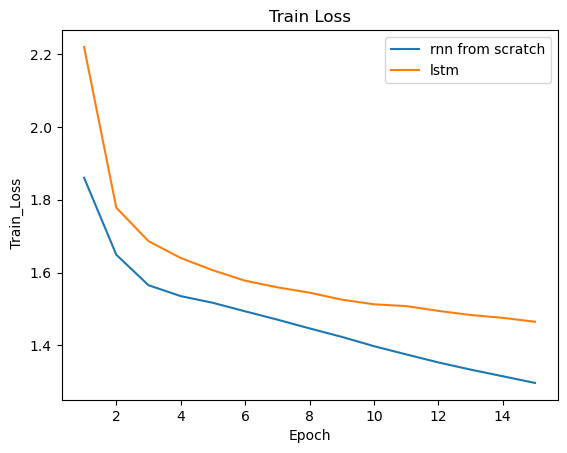

In [30]:
sns.lineplot(data=rnn, x='Epoch', y=' Train_Loss', label='rnn from scratch').set(title='Train Loss')
sns.lineplot(data=lstm.iloc[:15, :], x='Epoch', y=' Train_Loss', label='lstm')

<Axes: title={'center': 'Val Loss'}, xlabel='Epoch', ylabel=' Val_Loss'>

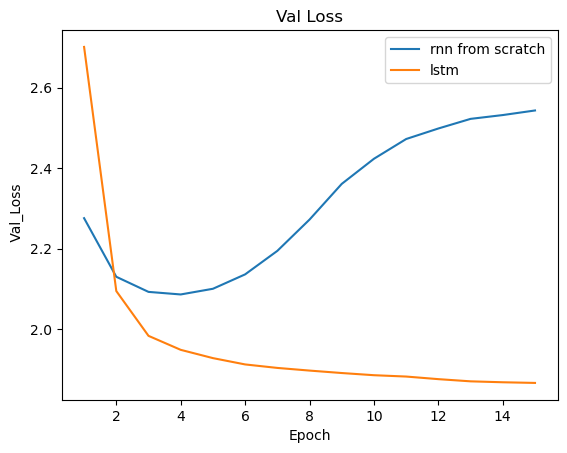

In [31]:
sns.lineplot(data=rnn, x='Epoch', y=' Val_Loss', label='rnn from scratch').set(title='Val Loss')
sns.lineplot(data=lstm.iloc[:15, :], x='Epoch', y=' Val_Loss', label='lstm')